**NOTE: This notebook is written for the Google Colab platform. However it can also be run (possibly with minor modifications) as a standard Jupyter notebook.** 



In [ ]:
#@title -- Import of Necessary Packages -- { display-mode: "form" }
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from IPython.utils.capture import capture_output
# for kmeans++
from sklearn.utils.extmath import row_norms, stable_cumsum
from sklearn.metrics.pairwise import euclidean_distances
import scipy.sparse as sp

In [ ]:
#@title -- Downloading Data -- { display-mode: "form" }
# also create a directory for storing any outputs
import os
os.makedirs("output", exist_ok=True)

In [ ]:
#@title -- Auxiliary Functions -- { display-mode: "form" }
cluster_colors = ['r', 'g', 'b', 'c', 'm']

class DummyContext:
    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        pass

def scatter_legend(ax, sc, labels, num_colors, color_array,
                   s, edgecolor):
    handles = []
    
    for i in range(num_colors):
        h = mlines.Line2D([0], [0], ls="", color=color_array[i],
                          ms=s, marker=sc.get_paths()[0],
                          markeredgecolor=edgecolor)
        handles.append(h)

    ax.legend(handles=handles, labels=labels)

def plot_data(
    data, cluster_centres=None, color='b', ax=None,
    cluster_colors=cluster_colors,
    edgecolors='k', labels=None,
    center_color='orange', center_size=200,
    legend=True
):
    if ax is None:
        ax = plt.gca()
        
    if labels is None:
        ax.scatter(data[:, 0], data[:, 1], s=50,
                   color=color, edgecolors=edgecolors)
    else:
        c = np.asarray(cluster_colors)[labels]
        
        sc = ax.scatter(data[:, 0], data[:, 1], s=50,
                        c=c, edgecolors=edgecolors,
                        #cmap=plt.cm.get_cmap('category10', np.max(labels)+1)
                       )
        
        if legend:
            nclusts = np.max(labels)+1
            scatter_legend(ax, sc, ['$c_{}$'.format(i) for i in range(nclusts)],
                           nclusts, cluster_colors, s=6, edgecolor='k')
        
    if not cluster_centres is None:
        ax.scatter(cluster_centres[:, 0],
                   cluster_centres[:, 1],
            s=center_size, c=center_color,
            edgecolors=edgecolors)

    ax.grid(ls='--')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_axisbelow(True)

def plot_kmeans_clustering(
   data, k=5, init='from_data', cluster_colors=cluster_colors,
   num_epochs=5, center_color='orange', center_size=200, seed=None,
   show_inline=True, fig_fname="output/kmeans_algo_{}.svg", figsize=(6, 5)
):
    num_clusters = k
    figs = []
    random = np.random.RandomState(seed)
    
    # initialize cluster positions
    if init == 'from_data':
        clust_centers = data[random.choice(range(data.shape[0]), [num_clusters])]
    elif init == 'uniform':
        dmin = data.min(axis=0)
        dmax = data.max(axis=0)
        clust_centers = random.uniform(dmin, dmax, [num_clusters, len(dmin)])
    elif init == 'kmeans++':
        clust_centers = kmeans_plus_plus(data, k, random)
    else:
        raise ValueError("Unknown init '{}'.".format(init))
    
    with DummyContext() if show_inline else capture_output():
        # plot the initial cluster centroids
        fig = plt.figure(figsize=figsize)
        figs.append(fig)
        plot_data(data, clust_centers,
                  center_size=center_size,
                  center_color=center_color)
        plt.show()

        if not fig_fname is None:
            fig.savefig(fig_fname.format(0),
                        bbox_inches='tight', pad_inches=0)
        
        clust_labels = np.zeros(len(data), dtype=np.int)    
        for epoch in range(1, num_epochs+1):
            clust_points = [[] for c in clust_centers]
            
            for ix, x in enumerate(data):
                minic = 0
                mindist = np.inf

                for ic, c in enumerate(clust_centers):
                    dist = np.linalg.norm(x - c)
                    if dist < mindist:
                        mindist = dist
                        minic = ic

                clust_points[minic].append(ix)
                clust_labels[ix] = minic

            # plot the assigment to clusters
            fig = plt.figure()
            figs.append(fig)
            plot_data(data, clust_centers, labels=clust_labels,
                      center_size=center_size, center_color=center_color)
            plt.show()

            if not fig_fname is None:
                fig.savefig(fig_fname.format(epoch),
                            bbox_inches="tight", pad_inches=0)

            # move the clusters
            for ic, cx in enumerate(clust_points):
                clust_centers[ic] = np.mean(data[cx, :], axis=0)

    return figs

def kmeans_plus_plus(X, n_clusters, random_state, n_local_trials=None):
    x_squared_norms = row_norms(X, squared=True)
    n_samples, n_features = X.shape

    centers = np.empty((n_clusters, n_features), dtype=X.dtype)

    assert x_squared_norms is not None, 'x_squared_norms None in _k_init'

    # Set the number of local seeding trials if none is given
    if n_local_trials is None:
        # This is what Arthur/Vassilvitskii tried, but did not report
        # specific results for other than mentioning in the conclusion
        # that it helped.
        n_local_trials = 2 + int(np.log(n_clusters))

    # Pick first center randomly
    center_id = random_state.randint(n_samples)
    if sp.issparse(X):
        centers[0] = X[center_id].toarray()
    else:
        centers[0] = X[center_id]

    # Initialize list of closest distances and calculate current potential
    closest_dist_sq = euclidean_distances(
        centers[0, np.newaxis], X, Y_norm_squared=x_squared_norms,
        squared=True)
    current_pot = closest_dist_sq.sum()

    # Pick the remaining n_clusters-1 points
    for c in range(1, n_clusters):
        # Choose center candidates by sampling with probability proportional
        # to the squared distance to the closest existing center
        rand_vals = random_state.random_sample(n_local_trials) * current_pot
        candidate_ids = np.searchsorted(stable_cumsum(closest_dist_sq),
                                        rand_vals)
        # XXX: numerical imprecision can result in a candidate_id out of range
        np.clip(candidate_ids, None, closest_dist_sq.size - 1,
                out=candidate_ids)

        # Compute distances to center candidates
        distance_to_candidates = euclidean_distances(
            X[candidate_ids], X, Y_norm_squared=x_squared_norms, squared=True)

        # update closest distances squared and potential for each candidate
        np.minimum(closest_dist_sq, distance_to_candidates,
                   out=distance_to_candidates)
        candidates_pot = distance_to_candidates.sum(axis=1)

        # Decide which candidate is the best
        best_candidate = np.argmin(candidates_pot)
        current_pot = candidates_pot[best_candidate]
        closest_dist_sq = distance_to_candidates[best_candidate]
        best_candidate = candidate_ids[best_candidate]

        # Permanently add best center candidate found in local tries
        if sp.issparse(X):
            centers[c] = X[best_candidate].toarray()
        else:
            centers[c] = X[best_candidate]

    return centers

## Clustering and the $k$-means Algorithm

Clustering is one of the tasks that fall under unsupervised learning. Clustering methods help to identify clusters (groups) of points in a dataset. A cluster is generally understood to be a group of points such that the points within the cluster are closer to each other (in terms of some distance measure) than w.r.t. points outside the cluster.

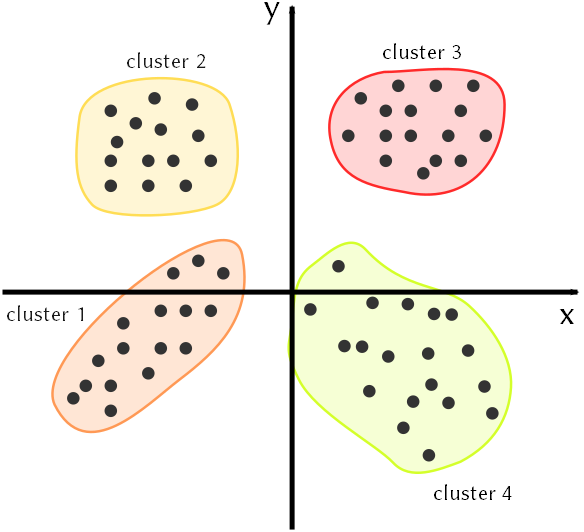

In 1 or 2-dimensional data it is typically easy to identify clusters visually, however, for multidimensional data it is much more difficult and we need to use methods that can find clusters automatically.

Clustering methods can be divided into two main categories by the structure of their output [[mmds2014]](#mmds2014):

* **Point-assignment methods** : Each point of the dataset is assigned into a cluster based on the relative distances among them (in terms of some distance measure). The method returns a cluster identifier for each point.
* **Hierarchical methods** : Rather than assign points into clusters, the method orders them within a hierarchical structure. This structure can be cut at any depth to get the kind of assignment provided by point-assignment methods. A diagram of this hierchical structure is called a **dendrogram** .
Another way to divide clustering methods is by how many times each point is considered [[mmds2014]](#mmds2014):

* **Iterative methods** : they need to iterate over the points several times;
* **Scan methods** : They only need to go through the dataset once.
This distinction makes a big difference especially in the case of very large datasets that do not fit in memory, because loading the data from the hard drive into memory over and over again can have a drastic impact on performance.
### $k$-means: The Principle

In the present notebook we will cover the principles underlying one of the simplest clustering methods, known as $k$-means and illustrate them using an example.

The number of clusters $k$, which $k$-means is to identify, needs to be determined beforehand. In the algorithm's first step, the centres of all $k$ clusters are initialized in some stochastic manner (e.g. sampled from a uniform distribution). The centres are then moved around iteratively so as to gradually minimize the distance between the cluster's centre and all the points that belong into the cluster. The name of the algorithm derives from the number of clusters $k$ and from the fact that cluster centres are determined by taking an empirical mean of the cluster's points.

More formally: let us suppose that we have a dataset $X = \{x_i\}$, composed of $N$ points from a $D$-dimensional space, which we want to split into $k$ clusters. Let us denote the clusters with $C = \{c_j\}$. The centre of cluster $c_j$ will be denoted $\mu_j$. The sum of the squares of the distances from the centre of cluster $c_j$ and its individual points $x_i \in c_j$ can be expressed using [[jain2010data]](#jain2010data)
\begin{equation}
J(c*j) = \sum* {x_i \in c_j} |x_i - \mu_j|^2,
\end{equation}
where $\|x_i - \mu_j\|$ is the Euclidean distance between vectors $x_i$ and $\mu_j$.

The goal of the $k$-means algorithm can then be expressed as the minimization of $J(c_j)$ across all clusters $c_j$. We can therefore define a summary criterion [[jain2010data]](#jain2010data)
\begin{equation}
J(C) = \sum*{j=1}^{k} \sum* {x_i \in c_j} | x_i - \mu_j |^2,
\end{equation}
which we will try to minimize.

Unfortunately, to find the global minimum of this function is an NP-hard task (the computational expense will scale unacceptably fast with the size of the problem; but more on NP elsewhere). This is why we are going to settle for what $k$-means offers, even though it only converges to a local, rather than a global minimum [[jain2010data]](#jain2010data). Its individual steps are summarized in the following pseudocode:

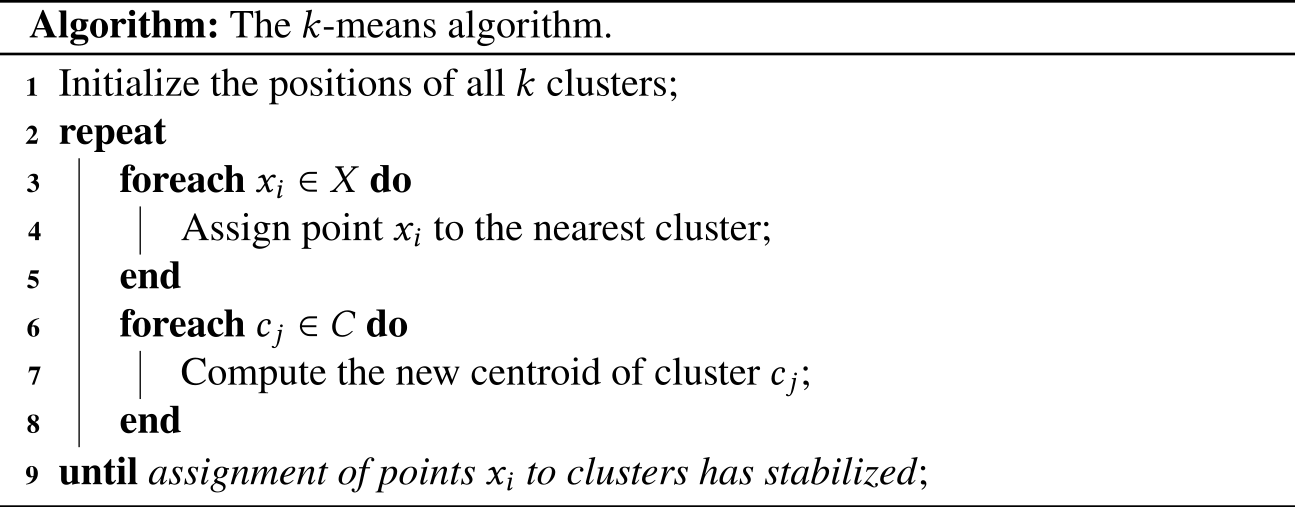

#### Assignment of Points

As we can see, after the initialization, $k$-means merely continues to alternate between two steps: the first assigns each point $x_i$ to the closest cluster $c_j$. Formally, we can express this assignment as follows:
\begin{equation}
c_j = \underset{c_j}{\mathrm{argmin}} | \mu_j - x_i |^2,
\end{equation}
i.e. we identify the cluster $c_j$, the centre of which is closest to point $x_i$ in terms of Euclidean distance.

#### Updating the Centres

The second step keeps updating the centres of all the clusters: they are determined as the average (empirical mean) of all points that belong into the cluster, i.e.:
\begin{equation}
\mu_j \leftarrow \frac{1}{|c*j|} \sum* {x_i \in c_j} x_i,
\end{equation}
where $|c_j|$ is the cardinality of cluster $c_j$, i.e. the total number of points $x_i \in c_j$, which belong into it.

The steps are repeated until the assignment of points into clusters has stabilized [[jain2010data]](#jain2010data).

### A Synthetic Dataset

To make the clustering procedure easy to visualize, we are going to create a synthetic 2-dimensional dataset with 5 very clear clusters using `sklearn`'s `datasets.make_blobs` function and we are going to plot it.



In [ ]:
data, labels = datasets.make_blobs(
    n_samples=600, random_state=3,
    cluster_std=0.75, centers=5)

fig = plt.figure(figsize=(6, 5))
plot_data(data)

### $k$-means: An Ilustration

In this section we will run $k$-means on the dataset. We are going to generate the figures in the next cell and then display them one by one and walk through all the individual steps.



In [ ]:
figs = plot_kmeans_clustering(data, seed=5, num_epochs=4, show_inline=False)

#### Initialization of Cluster Centres

As the first step, we are going to pick random points from the dataset and use them as our initial cluster centres.



In [ ]:
figs[0]

#### Assignment to Clusters

Next we go over all the points and assign each to the nearest cluster (indicated here using different colours).



In [ ]:
figs[1]

#### Updating Cluster Centres

Having assigned each point to some cluster, we will now walk over the points of each cluster, compute their average and move the cluster's centre there.



In [ ]:
figs[2]

#### Repeat

Then we just keep repeating the assignment and the update step iteratively until the assigments stabilize.



In [ ]:
display(figs[3])
display(figs[4])

### Good Initialization is Crucial

The positions of the initial cluster centres have dramatic impact on the results: if an unfortunate choice is made, the local minimum yielded by $k$-means can be severely suboptimal, which is illustrated in the following example.



In [ ]:
figs = plot_kmeans_clustering(data, seed=2, num_epochs=4,
                              fig_fname='output/kmeans_bad_init_{}.svg')

#### $k$-means++

In practice, therefore, practical $k$-means implementations typically use more sophisticated initialization methods such as $k$-means++ (which is the default initialization method in `scikit-learn`), which take care to distribute the intial cluster centres more uniformly.

The $k$-means++ approach prescribes the following procedure [[arthur2007k]](#arthur2007k):

# The first cluster centre is placed onto a uniformly randomly selected data point from dataset $X$.
# Subsequent cluster centres are generated one by one. They are again placed onto randomly selected points from the dataset, but the probability of a point being selected is now determined using
$$
p(x) = \frac{\Delta(x)^2}{\sum_{x_i \in X} \Delta(x_i)^2},
$$where $\Delta(x)$ denotes the distance from data point $x$ to the centre of the nearest already initialized cluster.

#### $k$-means++: An Example

The effect of this initialization method is shown below, where we use it to generate a number of initial cluster centres. Note how the initial centres are now already nicely distributed across clusters – even though a few iterations of $k$-means will still be necessary to get the stable assignments.



In [ ]:
fix, axes = plt.subplots(3, 3, figsize=(11, 9))
rand_state = np.random.RandomState(2)

for ax in axes.reshape(-1):
    cluster_init = kmeans_plus_plus(data, 5, rand_state)
    plot_data(data, cluster_init, ax=ax)
    
plt.tight_layout()

### Non-Euclidean Spaces and $k$-medoids

Not all spaces that our datasets come from are Euclidean. For $k$-means this is a problem, because taking the mean of the points that belong into a cluster may not make sense and may not even yield a valid point. To give a simple instance, let us consider a space of binary strings, e.g. strings $001$ and $101$ representing some concrete information.

Each bit in these strings carries meaning. It does not make sense to take these two strings and compute their element-wise average. That would yield $0.5, 0, 0.5$, which is not even a binary string. You also cannot just interpret the binary strings as numbers and take the average of those. After all, we have already mentioned that the strings do not simply encode numeric values: each bit in the string carries its distinct meaning.

#### $k$-medoids

Does that mean we can only do clustering in Euclidean spaces? Luckily, it does not. Provided that we can measure distances in a space, we can still define a measure of nearness for pairs of points. What we need to figure out then, is how to define the centre of a cluster without relying on averaging (empirical mean).

The $k$-medoids algorithm is an approach that works in exactly the same way as $k$-means except that instead of the mean it relies on the so-called medoids (also called clustroids). A medoid is a point from the original dataset (so we can be sure that it is a valid point) that is (in some sense) most central to the cluster and so we can choose it to represent the cluster [[elem_stat]](#elem_stat).

There is a number of ways to define medoids, e.g. [[mmds2014]](#mmds2014):

* The point with the least total distance to the other points in the cluster;
* The point with the least maximum distance to the other points in the cluster;
* ...
To find the medoid of a cluster, distances between all pairs of points need to be compared, so $k$-medoids is more computationally expensive than $k$-means [[elem_stat]](#elem_stat).



### References

<a id="jain2010data">[jain2010data]</a> Jain, A.K., 2010. Data clustering: 50 years beyond K-means. Pattern recognition letters, 31(8), pp.651-666.

<a id="arthur2007k">[arthur2007k]</a> Arthur, D. and Vassilvitskii, S., 2006. k-means++: The advantages of careful seeding. Stanford.

<a id="mmds2014">[mmds2014]</a> Rajaraman, A. and Ullman, J.D., 2011. Mining of massive datasets. Cambridge University Press. URL: <http://infolab.stanford.edu/~ullman/mmds/book.pdf>.

<a id="elem_stat">[elem_stat]</a> Friedman, J., Hastie, T. and Tibshirani, R., 2001. The elements of statistical learning (Vol. 1, No. 10). New York: Springer series in statistics. Ed. 2.

